In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from astropy.cosmology import LambdaCDM

cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)

## Setting up pdet function for Kilonovae base on AB magnitude

In [2]:
# peak absolute magnitude
def M_lambda_theta_v(
    theta_v,
    theta_0 = 1.0471975511965976, # 60 degrees
    M_lambda_0=-16.3, 
    Delta_M_lambda=4, 
    delta_M=[1,1],
):  
    if isinstance(delta_M, list):
        delta_M = np.random.uniform(*delta_M)
    elif isinstance(delta_M, float):
        pass
    else:
        raise ValueError("delta_M must be either a list or a float")

    result = np.zeros_like(theta_v)

    for i, theta in enumerate(theta_v):
        if theta<=theta_0:
            result[i] = M_lambda_0 + Delta_M_lambda * ((1 - np.cos(theta)) / (1 - np.cos(theta_0))) + delta_M
        else:
            result[i] = M_lambda_0 + Delta_M_lambda + delta_M

    return result

# apparent magnitude
def m_lambda_theta_v(
    theta_v,
    dl = None, # in Mpc
    z = None,
    theta_0 = 1.0471975511965976, # 60 degrees
    M_lambda_0=-16.3, 
    Delta_M_lambda=4, 
    delta_M=[1,1],
):

    if dl is None and z is None:
        raise ValueError("Either dl or z must be provided")
    elif dl is None:
        dl = cosmo.luminosity_distance(z).value
    M_lambda = M_lambda_theta_v(theta_v, theta_0, M_lambda_0, Delta_M_lambda, delta_M)

    return M_lambda + 5 * np.log10(dl) + 25

# pdet
def pdet_kne(
    theta_v, # in rad
    dl = None, # in Mpc
    z = None,
    theta_0 = 1.0471975511965976, # 60 degrees
    M_lambda_0=-16.3, 
    Delta_M_lambda=4, 
    delta_M=[1,1],
    detector_threshold=20.5, # ZTF threshold
    f_red = 0.2, # fraction of kilonovae that lacks blue component
):
    len_ = len(theta_v)
    m_lambda = m_lambda_theta_v(theta_v, dl, z, theta_0, M_lambda_0, Delta_M_lambda, delta_M)


    # pdet
    pdet = np.zeros_like(m_lambda)
    pdet[m_lambda < detector_threshold] = 1

    if (f_red!=0.0) and (f_red is not None) and (isinstance(f_red, float)):
        # choose f_red fraction and set pdet to 0
        # draw random number between 0 and 1 for each element in pdet
        gr_60_deg = np.rad2deg(theta_v) > 60
    
        idx_below_18 = (m_lambda < 18) & gr_60_deg & (pdet==1) & (np.random.uniform(0, 1, len_) < f_red)
        idx_between_18_20 = (m_lambda >= 18) & (m_lambda < 20) & gr_60_deg & (pdet==1) & (np.random.uniform(0, 1, len_) < f_red)
        idx_above_20 = (m_lambda >= 20) & gr_60_deg

        # print(np.sum(idx_below_18))
        # print(np.sum(idx_between_18_20))
        # print(np.sum(idx_above_20))
        
        if np.sum(idx_above_20) != 0:
            num_above_20 = np.sum(idx_above_20)
            fraction_above_20 = num_above_20 / len(m_lambda)
            idx_above_20 &= (np.random.uniform(0, 1, len_) < f_red*(1+1/fraction_above_20)) & (pdet==1)
            pdet[idx_above_20] = 0

        # print(np.sum(idx_above_20))

        pdet[idx_below_18] = 0
        pdet[idx_between_18_20] = 0
        
        
    return pdet

In [153]:
pdet_kne(np.ones(10000)*np.deg2rad(62), np.ones(10000)*20, f_red=0.1, delta_M=0.0);

0
1010
0


54
184
31052


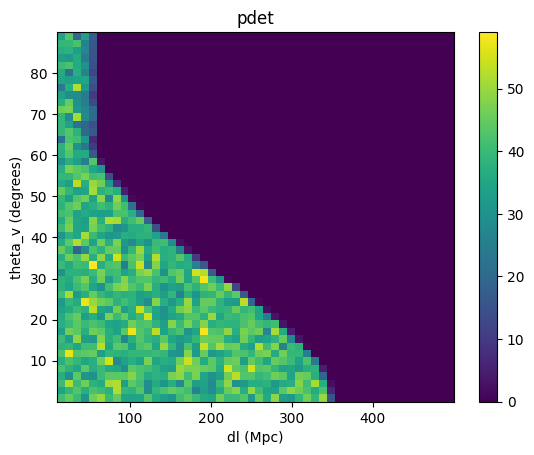

In [159]:
# uniform distribution of theta_v and dl
theta_v = np.random.uniform(0, np.pi/2, 100000)
dl = np.random.uniform(10, 500, 100000)

pdet = pdet_kne(theta_v, dl, f_red=0.1, delta_M=[-1,1])

# 2D histogram
plt.hist2d(dl, np.rad2deg(theta_v), bins=50, weights=pdet, cmap="viridis")
plt.colorbar()
plt.xlabel("dl (Mpc)")
plt.ylabel("theta_v (degrees)")
plt.title("pdet")
plt.show()

In [125]:
np.sum(test==0)

31

In [11]:
np.log10(1e5)

5.0

In [ ]:
def rjs_with_cross_section_mp(self, param_dict):
        """
        Function to conduct rejection sampling wrt cross_section, multiprocessing

        Parameters
        ----------
        param_dict : `dict`
            dictionary of lens parameters and source parameters

        Returns
        -------
        lens_params : `dict`
            dictionary of lens parameters after rejection sampling
        """


        theta_E_cut = 2.9243287409459857e-08

        # Pre-filter param_dict directly
        idx = param_dict["theta_E"] > theta_E_cut
        param_dict = {key: val[idx] 
                    for key, val in param_dict.items()}

        size = len(param_dict["theta_E"])  # Update size after filtering
        theta_E = param_dict["theta_E"]
        e1 = param_dict["e1"]
        e2 = param_dict["e2"]
        gamma = param_dict["gamma"]
        gamma1 = param_dict["gamma1"]
        gamma2 = param_dict["gamma2"]

        idx = np.arange(size, dtype=int)
        params = np.array([theta_E, e1, e2, gamma, gamma1, gamma2, idx]).T

        cross_section = np.zeros(size)  # Directly create filtered array

        with Pool(processes=self.npool) as pool:
            for result in pool.imap_unordered(cross_section_mp, params): 
                idx_, tau_ = result
                cross_section[idx_] = tau_

        max_ = np.max(cross_section)
        u = np.random.uniform(0, max_, size=size)
        mask = u < cross_section

        # Return the dictionary with the mask applied
        dict_ = {key: val[mask] for key, val in param_dict.items()}
        dict_["cross_section"] = cross_section[mask]

        return dict_